In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
import wget
url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv'
myfile = wget.download(url)

100% [..............................................................................] 70827 / 70827

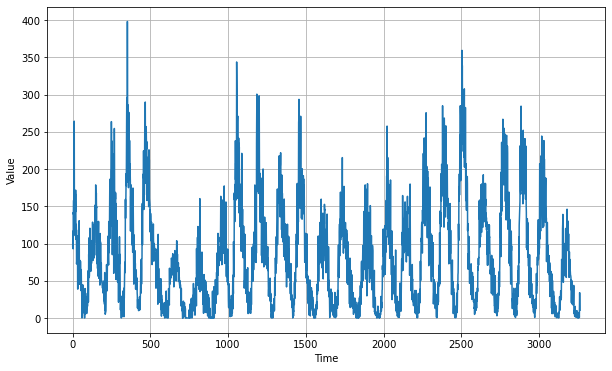

In [4]:
import csv
time_step = []
sunspots = []

with open('E:\\TensorflowDeveloperCertification\\Tensorflow _Ravi/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
series

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

In [7]:
time

array([   0,    1,    2, ..., 3262, 3263, 3264])

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 15s 479ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 5s 420ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 6s 418ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 5s 403ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 6s 450ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 6s 421ms/step - loss: 62.9767 - mae: 63.4739
Epoch 7/100
12/12 [==============================] - 6s 462ms/step - loss: 59.8143 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 6s 461ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 5s 404ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12

12/12 [==============================] - 5s 402ms/step - loss: 33.1678 - mae: 33.6640
Epoch 83/100
12/12 [==============================] - 6s 439ms/step - loss: 31.2220 - mae: 31.7177
Epoch 84/100
12/12 [==============================] - 5s 414ms/step - loss: 34.2445 - mae: 34.7409
Epoch 85/100
12/12 [==============================] - 5s 419ms/step - loss: 33.2869 - mae: 33.7829
Epoch 86/100
12/12 [==============================] - 5s 422ms/step - loss: 31.2392 - mae: 31.7346
Epoch 87/100
12/12 [==============================] - 6s 454ms/step - loss: 39.4772 - mae: 39.9733
Epoch 88/100
12/12 [==============================] - 5s 420ms/step - loss: 50.6015 - mae: 51.0993
Epoch 89/100
12/12 [==============================] - 6s 429ms/step - loss: 47.3931 - mae: 47.8909
Epoch 90/100
12/12 [==============================] - 6s 449ms/step - loss: 69.4205 - mae: 69.9190
Epoch 91/100
12/12 [==============================] - 6s 421ms/step - loss: 52.7681 - mae: 53.2661
Epoch 92/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

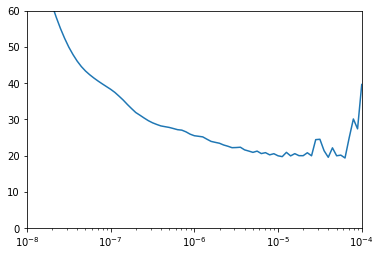

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 13s 198ms/step - loss: 47.7137 - mae: 48.2109
Epoch 2/500
30/30 [==============================] - 7s 211ms/step - loss: 26.8710 - mae: 27.3659
Epoch 3/500
30/30 [==============================] - 6s 204ms/step - loss: 22.9806 - mae: 23.4751
Epoch 4/500
30/30 [==============================] - 7s 216ms/step - loss: 20.2772 - mae: 20.7706
Epoch 5/500
30/30 [==============================] - 7s 229ms/step - loss: 19.2560 - mae: 19.7484
Epoch 6/500
30/30 [==============================] - 7s 226ms/step - loss: 19.5879 - mae: 20.0800
Epoch 7/500
30/30 [==============================] - 6s 204ms/step - loss: 18.6144 - mae: 19.1064
Epoch 8/500
30/30 [==============================] - 7s 212ms/step - loss: 17.9053 - mae: 18.3964
Epoch 9/500
30/30 [==============================] - 7s 213ms/step - loss: 17.9646 - mae: 18.4558
Epoch 10/500
30/30 [==============================] - 6s 204ms/step - loss: 18.4124 - mae: 18.9038
Epoch 11/500
30/30

30/30 [==============================] - 6s 178ms/step - loss: 16.4206 - mae: 16.9083 0s - loss: 16.3786 - mae: 1
Epoch 82/500
30/30 [==============================] - 6s 179ms/step - loss: 16.2015 - mae: 16.6894
Epoch 83/500
30/30 [==============================] - 6s 178ms/step - loss: 16.1216 - mae: 16.6092
Epoch 84/500
30/30 [==============================] - 6s 177ms/step - loss: 16.2185 - mae: 16.7062
Epoch 85/500
30/30 [==============================] - 6s 177ms/step - loss: 16.1257 - mae: 16.6135
Epoch 86/500
30/30 [==============================] - 6s 177ms/step - loss: 16.5344 - mae: 17.0226
Epoch 87/500
30/30 [==============================] - 6s 177ms/step - loss: 16.5439 - mae: 17.0326
Epoch 88/500
30/30 [==============================] - 6s 180ms/step - loss: 16.2187 - mae: 16.7067
Epoch 89/500
30/30 [==============================] - 6s 181ms/step - loss: 16.3466 - mae: 16.8346
Epoch 90/500
30/30 [==============================] - 6s 178ms/step - loss: 16.0297 - mae: 16.

30/30 [==============================] - 6s 176ms/step - loss: 15.7554 - mae: 16.2438 2s - loss: 15.63
Epoch 154/500
30/30 [==============================] - 6s 178ms/step - loss: 15.8420 - mae: 16.3301
Epoch 155/500
30/30 [==============================] - 6s 179ms/step - loss: 15.5718 - mae: 16.0595 1s - loss: 15.3793 - m
Epoch 156/500
30/30 [==============================] - 6s 179ms/step - loss: 15.7592 - mae: 16.2474
Epoch 157/500
30/30 [==============================] - 6s 177ms/step - loss: 16.1738 - mae: 16.6624
Epoch 158/500
30/30 [==============================] - 6s 178ms/step - loss: 15.8117 - mae: 16.2988 4s - lo
Epoch 159/500
30/30 [==============================] - 6s 183ms/step - loss: 15.6462 - mae: 16.1350
Epoch 160/500
30/30 [==============================] - 6s 179ms/step - loss: 15.6196 - mae: 16.1073
Epoch 161/500
30/30 [==============================] - 6s 177ms/step - loss: 15.6984 - mae: 16.1866
Epoch 162/500
30/30 [==============================] - 6s 177ms/st

30/30 [==============================] - 6s 177ms/step - loss: 15.4563 - mae: 15.9435 3s - loss: 15.1909 - - ETA: 1s - loss: 15.3584 - ma
Epoch 228/500
30/30 [==============================] - 6s 176ms/step - loss: 15.5272 - mae: 16.0153
Epoch 229/500
30/30 [==============================] - 6s 176ms/step - loss: 15.5081 - mae: 15.9957 3s - loss: 15.3911 - ETA: 0s - loss: 15.4762 - mae: 15.
Epoch 230/500
30/30 [==============================] - 6s 179ms/step - loss: 15.4526 - mae: 15.9400
Epoch 231/500
30/30 [==============================] - 6s 178ms/step - loss: 15.4316 - mae: 15.9190
Epoch 232/500
30/30 [==============================] - 5s 176ms/step - loss: 15.5220 - mae: 16.0095 2s - loss: 15.4367
Epoch 233/500
30/30 [==============================] - 6s 177ms/step - loss: 15.2525 - mae: 15.7395
Epoch 234/500
30/30 [==============================] - 6s 180ms/step - loss: 15.3875 - mae: 15.8750
Epoch 235/500
30/30 [==============================] - 6s 177ms/step - loss: 15.3873 - 

30/30 [==============================] - 5s 175ms/step - loss: 15.1218 - mae: 15.6083 0s - loss: 15.0834 - mae: 15
Epoch 302/500
30/30 [==============================] - 6s 178ms/step - loss: 14.9327 - mae: 15.4190 1s - loss: 14.7984 - m
Epoch 303/500
30/30 [==============================] - 5s 176ms/step - loss: 15.2205 - mae: 15.7074
Epoch 304/500
30/30 [==============================] - 6s 190ms/step - loss: 14.9649 - mae: 15.4503 4s - los
Epoch 305/500
30/30 [==============================] - 6s 188ms/step - loss: 14.7640 - mae: 15.2502
Epoch 306/500
30/30 [==============================] - 5s 176ms/step - loss: 15.1644 - mae: 15.6508
Epoch 307/500
30/30 [==============================] - 6s 178ms/step - loss: 15.0883 - mae: 15.5739 4s - loss:  - ETA: 0s - loss: 15.0523 - mae: 15
Epoch 308/500
30/30 [==============================] - 5s 176ms/step - loss: 14.9352 - mae: 15.4210 1s - loss: 14.8597 - mae: 15.345 - ETA: 1s - loss: 14.8689 - mae: 
Epoch 309/500
30/30 [=================

30/30 [==============================] - 6s 177ms/step - loss: 14.8233 - mae: 15.3081
Epoch 378/500
30/30 [==============================] - 6s 178ms/step - loss: 14.8656 - mae: 15.3514
Epoch 379/500
30/30 [==============================] - 6s 176ms/step - loss: 14.8229 - mae: 15.3074
Epoch 380/500
30/30 [==============================] - 6s 177ms/step - loss: 14.6748 - mae: 15.1593
Epoch 381/500
30/30 [==============================] - 6s 178ms/step - loss: 14.7539 - mae: 15.2389
Epoch 382/500
30/30 [==============================] - 6s 178ms/step - loss: 14.5353 - mae: 15.0196
Epoch 383/500
30/30 [==============================] - 5s 175ms/step - loss: 14.8330 - mae: 15.3190
Epoch 384/500
30/30 [==============================] - 6s 178ms/step - loss: 14.5824 - mae: 15.0665 4s - los
Epoch 385/500
30/30 [==============================] - 6s 177ms/step - loss: 14.7385 - mae: 15.2228
Epoch 386/500
30/30 [==============================] - 6s 178ms/step - loss: 14.5532 - mae: 15.0384
Epoch

30/30 [==============================] - 6s 176ms/step - loss: 14.3313 - mae: 14.8154: 4s - loss: 14.0089 - mae: 14.4 - ETA: 4s - los
Epoch 455/500
30/30 [==============================] - 6s 179ms/step - loss: 14.4093 - mae: 14.8937
Epoch 456/500
30/30 [==============================] - 6s 177ms/step - loss: 14.4009 - mae: 14.8865 3s - loss: 14.3264 - m - ETA: 1s - loss: 14.2943 - m
Epoch 457/500
30/30 [==============================] - 5s 175ms/step - loss: 14.6010 - mae: 15.0865 3s - loss: 14.5
Epoch 458/500
30/30 [==============================] - 5s 174ms/step - loss: 14.4694 - mae: 14.9542 4s - loss
Epoch 459/500
30/30 [==============================] - 6s 194ms/step - loss: 14.3749 - mae: 14.8595 4s - lo
Epoch 460/500
30/30 [==============================] - 5s 176ms/step - loss: 14.5412 - mae: 15.0269
Epoch 461/500
30/30 [==============================] - 5s 175ms/step - loss: 14.3146 - mae: 14.7992 2s - loss: 14.2196 -
Epoch 462/500
30/30 [==============================] - 5s 

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

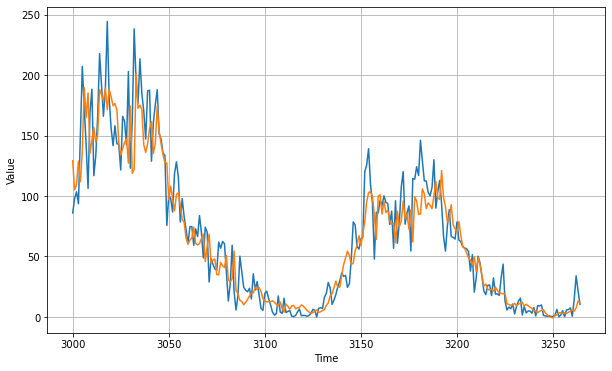

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.240884

<Figure size 432x288 with 0 Axes>

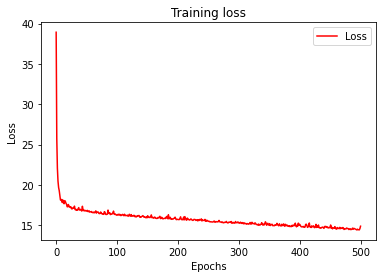

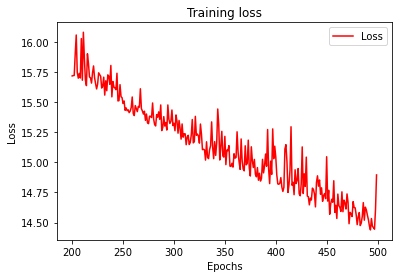

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[129.04431    105.11751    109.268425   128.87776    111.77514
 136.66818    189.69893    164.79538    185.19066    135.14418
 146.1318     156.89587    144.59161    150.94699    188.06772
 183.81177    178.83047    189.14427    171.52533    187.8438
 182.19182    174.62994    176.5459     171.16974    144.21036
 133.80296    139.3842     144.25046    147.2449     127.14858
 174.4253     118.753365   122.06561    201.62166    172.40979
 175.07777    171.43483    142.2894     136.04248    143.28091
 155.49384    161.52216    135.21605    143.61563    174.21193
 153.74628    143.13748    134.42119    127.4106     127.301765
  96.99003    108.1269      97.9634      87.727196   101.29299
 102.74241     92.26889     80.56587     78.191956    65.30623
  60.13179     63.446648    65.36268     74.30679     60.872746
  59.54983     60.647022    64.91973     68.46757     45.811317
  58.23915     68.42478     44.337704    47.124718    47.901855
  35.01228     34.85709     45.098625    42.35171   

# DNN

In [19]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [20]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [21]:
import wget
url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv'
myfile = wget.download(url)

100% [..............................................................................] 70827 / 70827

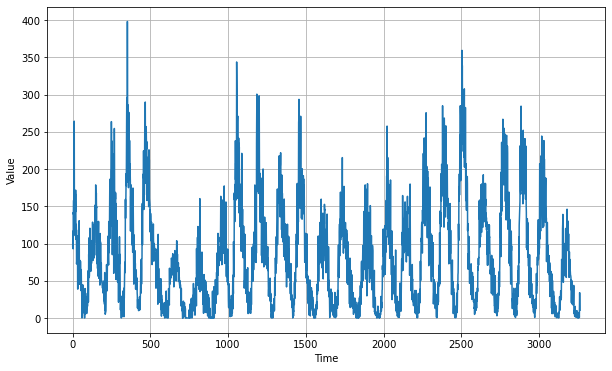

In [22]:
import csv
time_step = []
sunspots = []

with open('E:\\TensorflowDeveloperCertification\\Tensorflow _Ravi/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [23]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [25]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

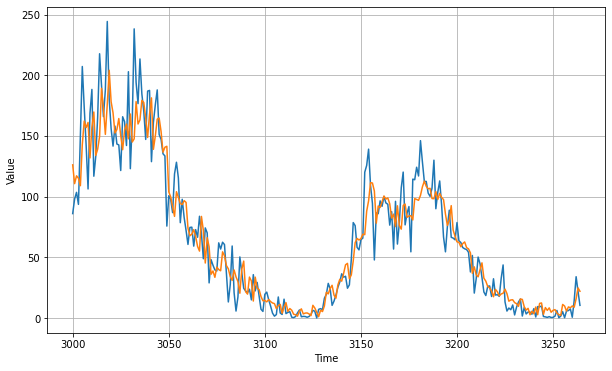

In [26]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

13.665932